# 3rd place solution 
[リンク](https://www.kaggle.com/code/tihonby/march-madness-3th-place-solution)

In [144]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from scipy.interpolate import UnivariateSpline
from sklearn import preprocessing
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.model_selection import KFold
from tqdm import tqdm

sys.path.append(os.path.abspath("/workspace"))
sys.path.append("C:\\Users\\81809\\Documents\\ALL_CODE\\kaggle\\March Machine Learning Mania 2025")
with initialize_config_module(version_base=None, config_module="conf"):
    cfg = compose(
        config_name="base.yaml",
        overrides=[
            "exp=exp002" #defaultexp001->exp002のオーバーライド
        ],
    )
    
    OmegaConf.resolve(cfg)
    print("Omega conf is below")
    print(OmegaConf.to_yaml(cfg))
    
"""
#こんな感じでkeyとval取得できる
print(cfg.dir.keys())
print(cfg.exp)"""

INPUT_PATH = os.path.join("..","..", cfg.dir.input_dir)
OUTPUT_PATH = cfg.dir.output_dir
SRC_PATH = cfg.dir.src_path
CONF_PATH = cfg.dir.conf_path

sys.path.append(SRC_PATH)

Omega conf is below
dir:
  input_dir: ../input
  output_dir: ../output/2025-02-23_22-24-59
  src_path: ../src
  conf_path: ../conf
model:
  epochs: 10
  lr: 0.001
exp:
  model:
    hidden_size: 100
    learning_rate: 0.1
    batch_size: 640
    num_epochs: 50



In [145]:
PREVIOUS_SEASONS_MEN = True 
PREVIOUS_SEASONS_WOMEN = True 
USE_GPU = False

追加特徴量
- EFFG: フィールドゴール成功率
- EFFG3: フィールドゴール3p成功率
- DARE: フィールドゴールにおける3P率
- TOQUETOQUE: フィールドゴールにおけるアシスト数

In [146]:
tourney_results = pd.read_csv(os.path.join(INPUT_PATH, 'MNCAATourneyDetailedResults.csv'))
seeds = pd.read_csv(os.path.join(INPUT_PATH, 'MNCAATourneySeeds.csv'))
regular_results = pd.read_csv(os.path.join(INPUT_PATH, 'MRegularSeasonDetailedResults.csv'))

regular_results['WEFFG'] = regular_results['WFGM'] / regular_results['WFGA']
regular_results['WEFFG3'] = regular_results['WFGM3'] / regular_results['WFGA3']
regular_results['WDARE'] = regular_results['WFGM3'] / regular_results['WFGM']
regular_results['WTOQUETOQUE'] = regular_results['WAst'] / regular_results['WFGM']

regular_results['LEFFG'] = regular_results['LFGM'] / regular_results['LFGA']
regular_results['LEFFG3'] = regular_results['LFGM3'] / regular_results['LFGA3']
regular_results['LDARE'] = regular_results['LFGM3'] / regular_results['LFGM']
regular_results['LTOQUETOQUE'] = regular_results['LAst'] / regular_results['LFGM']

regular_results.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LBlk,LPF,WEFFG,WEFFG3,WDARE,WTOQUETOQUE,LEFFG,LEFFG3,LDARE,LTOQUETOQUE
0,2003,10,1104,68,1328,62,N,0,27,58,...,2,20,0.465517,0.214286,0.111111,0.481481,0.415094,0.200000,0.090909,0.363636
1,2003,10,1272,70,1393,63,N,0,26,62,...,6,16,0.419355,0.400000,0.307692,0.615385,0.358209,0.250000,0.250000,0.291667
2,2003,11,1266,73,1437,61,N,0,24,58,...,5,23,0.413793,0.444444,0.333333,0.625000,0.301370,0.115385,0.136364,0.409091


In [147]:
def prepare_data(df_data):
    df = df_data.copy()
    df.rename(columns = {'WLoc':'location'}, inplace = True )
    
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'location', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]
    
    df.columns = df.columns.str.replace('W','T1_')
    df.columns = df.columns.str.replace('L','T2_')
    dfswap.columns = dfswap.columns.str.replace('L','T1_')
    dfswap.columns = dfswap.columns.str.replace('W','T2_')

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    return output

In [148]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [149]:
regular_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'T1_EFFG', 'T1_EFFG3', 'T1_DARE', 'T1_TOQUETOQUE', 'T2_EFFG',
       'T2_EFFG3', 'T2_DARE', 'T2_TOQUETOQUE', 'PointDiff'],
      dtype='object')

In [150]:
# Choose the features that you want
boxscore_cols = ['T1_Score', 'T2_Score',
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff', 'T1_EFFG', 'T1_EFFG3', 'T1_DARE', 'T1_TOQUETOQUE', 'T2_EFFG', 'T2_EFFG3', 'T2_DARE', 'T2_TOQUETOQUE']

In [151]:
# Choose a function to aggregate
funcs = [np.mean]
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head(3)

C:\Users\81809\AppData\Local\Temp\ipykernel_5504\4099716295.py:3: FutureWarning: The provided callable <function mean at 0x0000018EA9263880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()


,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,...,T2_Blkmean,PointDiffmean,T1_EFFGmean,T1_EFFG3mean,T1_DAREmean,T1_TOQUETOQUEmean,T2_EFFGmean,T2_EFFG3mean,T2_DAREmean,T2_TOQUETOQUEmean
0,2003,1102,57.250000,57.000000,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,...,1.571429,0.250000,0.567934,0.449882,0.436300,0.746082,0.404633,0.314624,0.232174,0.407789
1,2003,1103,78.777778,78.148148,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,...,2.851852,0.629630,0.542563,0.362828,0.186769,0.593458,0.457975,0.307565,0.235592,0.495248
2,2003,1104,69.285714,65.000000,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,...,3.178571,4.285714,0.444393,0.347418,0.280960,0.551302,0.385595,0.305596,0.275764,0.489873


In [152]:
# val_0ps - current season value
# weight_0 - current season weight
# val_1ps - last season value
# val_2ps - the value of the season before last

def get_mean_of_3_season(val_2ps, val_1ps, val_0ps, 
                         weight_2=1, weight_1=2, weight_0=3, 
                         degree_weight=1.0
                         ):
    weight_2 = weight_2**degree_weight
    weight_1 = weight_1**degree_weight
    weight_0 = weight_0**degree_weight
    if val_2ps == 0  and val_1ps == 0:
        return val_0ps
    elif val_2ps == 0:
        return (val_1ps*weight_2 + val_0ps*weight_1)/(weight_2 + weight_1)
    else:
        sum_of_values = val_2ps*weight_2 + val_1ps*weight_1 + val_0ps*weight_0
        return sum_of_values/(weight_2 + weight_1 + weight_0)

def get_3_feature(df_team, feature):
    value_2_seasons_ago = 0
    value_1_season_ago = 0
    value_0_season_ago = 0
    for _, val in df_team.iterrows():
        value_2_seasons_ago = value_1_season_ago
        value_1_season_ago = value_0_season_ago
        value_0_season_ago = val[feature]
    return value_2_seasons_ago, value_1_season_ago, value_0_season_ago

def write_mean_of_3_seasons(df, features, degree_weight=1.0):
    df_copy = df.copy()
    suffix = "_mn3s"
    for ft in features:
        df_copy[ft + suffix] = 0
    for idx, val in tqdm(df_copy.iterrows(), total=len(df_copy)):
        team = val.T1_TeamID
        season = val.Season
        df_team = df_copy[(df_copy.T1_TeamID == team)&
                          (df_copy.Season <= season)&
                          (df_copy.Season > season-3)]
        for ft in features:
            val_2ps, val_1ps, val_0ps = get_3_feature(df_team, ft)
            ft_mean_3 = get_mean_of_3_season(val_2ps, val_1ps, val_0ps, degree_weight=degree_weight)
            df_copy.loc[idx, ft + suffix] = ft_mean_3
    return df_copy

In [153]:
#Make two copies of the data
if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_Scoremean", "T1_FGAmean",  "T1_FGA3mean"]
    season_statistics_with_3_seas = write_mean_of_3_seasons(
        season_statistics, features_for_calc, degree_weight=1.0
    )
    season_statistics_T1 = season_statistics_with_3_seas.copy()
    season_statistics_T2 = season_statistics_with_3_seas.copy()
else:
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

season_statistics_T1[1000:1003]

  0%|          | 0/7981 [00:00<?, ?it/s]C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '57.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '39.785714285714285' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.821428571428573' has dtype incompatible with int64, please explicitly cast to a 

,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,...,T1_EFFG3mean,T1_DAREmean,T1_TOQUETOQUEmean,T2_EFFGmean,T2_EFFG3mean,T2_DAREmean,T2_TOQUETOQUEmean,T1_Scoremean_mn3s,T1_FGAmean_mn3s,T1_FGA3mean_mn3s
1000,2006,1122,71.870968,71.258065,24.677419,54.193548,5.483871,16.387097,10.516129,14.032258,...,0.365952,0.242192,0.620508,0.421951,0.297472,0.258723,0.499596,68.402746,53.584869,16.892953
1001,2006,1123,62.538462,65.461538,22.230769,52.192308,5.307692,14.769231,11.384615,11.500000,...,0.362453,0.243927,0.580013,0.374412,0.328791,0.334433,0.653090,66.213014,54.194258,16.272402
1002,2006,1124,63.176471,72.529412,21.588235,54.294118,7.882353,21.176471,10.000000,10.941176,...,0.416339,0.314709,0.500303,0.397557,0.379487,0.315693,0.543932,63.841322,52.992738,20.748729


In [154]:
# "T1_Scoremean",  "T1_Scoremean_mn3s" - values are different
# "T1_FGAmean", "T1_FGAmean_mn3s"      - values are different
# "T1_FGA3mean", "T1_FGA3mean_mn3s"    - values are different
if PREVIOUS_SEASONS_MEN:
    season_statistics_T1[["T1_Scoremean", "T1_Scoremean_mn3s", 
                          "T1_FGAmean", "T1_FGAmean_mn3s",
                          "T1_FGA3mean", "T1_FGA3mean_mn3s" ]][1000:1003]
season_statistics_with_3_seas.columns

Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean',
       'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean',
       'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean',
       'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean',
       'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean', 'T1_EFFGmean',
       'T1_EFFG3mean', 'T1_DAREmean', 'T1_TOQUETOQUEmean', 'T2_EFFGmean',
       'T2_EFFG3mean', 'T2_DAREmean', 'T2_TOQUETOQUEmean', 'T1_Scoremean_mn3s',
       'T1_FGAmean_mn3s', 'T1_FGA3mean_mn3s'],
      dtype='object')

In [155]:
season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

# We don't have the box score statistics in the prediction bank. So drop it.
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head(3)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71


In [156]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(12300, 5)

In [157]:
def normalize_column(values):
    themean = np.mean(values)
    thestd = np.std(values)
    norm = (values - themean)/(thestd) 
    return(pd.DataFrame(norm))

def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = normalize_column(quality['quality'])
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    print(quality['quality'].mean(), quality['quality'].std())
    return quality

# This is metric to measure the team's strength, in this case, this is a logistic regression and we
# the coefficients
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024),
                        # team_quality(2025)
                        ]).reset_index(drop=True)

2.4655966220912995 1.1438308076996118
2.5337210881455925 0.8277700700394227
0.8979844550690217 0.5826397837860905
0.9243847418447978 0.38339610379131966
2.536260111590678 1.1613689664538032
2.53181435227881 1.9986516346167762
0.8150475571807926 0.3726513935377684
0.995112191848605 1.6762242412336152


c:\Users\81809\anaconda3\envs\deep_learning_pytorch\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


0.8711110392423691 0.8980072693247351
2.3792435933658367 1.216005633944503


c:\Users\81809\anaconda3\envs\deep_learning_pytorch\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.4796475970664957 1.286728195555418
2.4720221629615855 1.2563235074720704
0.7831527339485117 0.5203145405743224
2.316613174579133 1.3001289926761506


In [158]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data.head()
tourney_data['T1_quality'].fillna(0.2, inplace = True)
tourney_data['T2_quality'].fillna(0.2, inplace = True)
tourney_data.T2_quality.isnull().sum()

seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2623142244.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tourney_data['T1_quality'].fillna(0.2, inplace = True)
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2623142244.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [159]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

#Optional but not relevant
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    tourney_data_with_3_seas = write_mean_of_3_seasons(tourney_data, features_for_calc, degree_weight=1.0)
    tourney_data = tourney_data_with_3_seas.copy()

tourney_data[1000:1002]

  0%|          | 0/2764 [00:00<?, ?it/s]C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20000000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20000000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
  2%|▏         | 65/2764 [00:00<00:12, 210.79it/s]C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.666666666666666'

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,...,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
1000,2018,136,1437,87,1347,61,87.058824,70.882353,31.029412,61.529412,...,56.027239,21.721576,0.678509,0.148224,1,16,-15,0.854536,1.107569,1.0
1001,2018,137,1120,62,1158,58,83.375000,73.312500,27.125000,61.781250,...,54.915494,19.768850,1.519076,0.161688,4,13,-9,1.519076,0.845587,4.0


In [160]:
# The descriptive feature is the score, not the winner
# y = tourney_data['T1_Score'] - tourney_data['T2_Score']
# y.describe()

if PREVIOUS_SEASONS_MEN:
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"] +\
        ["T1_quality_mn3s", "T2_quality_mn3s", "T1_seed_mn3s"]
else:
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"] 

print(len(features))

72


In [161]:
sub = pd.read_csv(os.path.join(INPUT_PATH, 'SampleSubmission2023.csv'))

sub["Season"] = sub["ID"].apply(lambda x: x[0:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.shape

(130683, 5)

In [162]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left') 
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
print(sub.shape)
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
print(sub.shape)
sub.head(3)

(65703, 69)
(65703, 71)
(2278, 73)
(2278, 74)


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T2_opponent_DAREmean,T2_opponent_TOQUETOQUEmean,T2_Scoremean_mn3s,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2023_1104_1112,0.5,2023,1104,1112,82.176471,68.5,27.764706,62.205882,10.058824,...,0.306292,0.481291,82.095023,59.657240,21.553922,1.0,1.009169,1,2,-1
1,2023_1104_1113,0.5,2023,1104,1113,82.176471,68.5,27.764706,62.205882,10.058824,...,0.335587,0.547442,69.344130,60.475079,23.030506,1.0,0.884573,1,11,-10
2,2023_1104_1116,0.5,2023,1104,1116,82.176471,68.5,27.764706,62.205882,10.058824,...,0.220724,0.430463,76.590729,59.454185,18.812590,1.0,0.869219,1,8,-7


In [163]:
print(sub.T2_quality.isnull().sum())
sub['T1_quality'].fillna(0.2, inplace = True)
sub['T2_quality'].fillna(0.2, inplace = True)
print(sub.T2_quality.isnull().sum())

if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    sub = write_mean_of_3_seasons(sub, features_for_calc, degree_weight=1.0)
    sub = sub.copy()
sub.head(3)

C:\Users\81809\AppData\Local\Temp\ipykernel_5504\3981203429.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sub['T1_quality'].fillna(0.2, inplace = True)
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\3981203429.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

49
0


  0%|          | 0/2278 [00:00<?, ?it/s]C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0000000000177853' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9053135769013544' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
100%|██████████| 2278/2278 [00:50<00:00, 45.07it/s] 


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
0,2023_1104_1112,0.5,2023,1104,1112,82.176471,68.5,27.764706,62.205882,10.058824,...,59.657240,21.553922,1.0,1.009169,1,2,-1,1.0,0.905314,1
1,2023_1104_1113,0.5,2023,1104,1113,82.176471,68.5,27.764706,62.205882,10.058824,...,60.475079,23.030506,1.0,0.884573,1,11,-10,1.0,0.905314,1
2,2023_1104_1116,0.5,2023,1104,1116,82.176471,68.5,27.764706,62.205882,10.058824,...,59.454185,18.812590,1.0,0.869219,1,8,-7,1.0,0.905314,1


In [164]:
teamdata = pd.read_csv(os.path.join(INPUT_PATH, 'WTeams.csv'))

sub = pd.merge(sub, teamdata, left_on = 'T1_TeamID', right_on = 'TeamID', how = 'left')
sub = pd.merge(sub, teamdata, left_on = 'T2_TeamID', right_on = 'TeamID', how = 'left')

sub.head(3)

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s,TeamID_x,TeamName_x,TeamID_y,TeamName_y
0,2023_1104_1112,0.5,2023,1104,1112,82.176471,68.5,27.764706,62.205882,10.058824,...,1,2,-1,1.0,0.905314,1,NaN,NaN,NaN,NaN
1,2023_1104_1113,0.5,2023,1104,1113,82.176471,68.5,27.764706,62.205882,10.058824,...,1,11,-10,1.0,0.905314,1,NaN,NaN,NaN,NaN
2,2023_1104_1116,0.5,2023,1104,1116,82.176471,68.5,27.764706,62.205882,10.058824,...,1,8,-7,1.0,0.905314,1,NaN,NaN,NaN,NaN


ここから下二つを調整していく

In [165]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess
normalize = "Normalizer"

param = {} 
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 #recommend change to ~0.02 for final run. Higher when debugging.
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10. Write 3 for debugging.
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] = 3 
# param['silent'] = 1
if USE_GPU: 
    param['tree_method'] ='gpu_hist'
df = tourney_data.copy()
df.insert(0,"ID","")
df.ID = [str(row.Season)+"_"+str(row.T1_TeamID)+"_"+str(row.T2_TeamID)for _, row in df.iterrows()]
df = df.fillna(0)
df["ScoreDiff"] = df['T1_Score'] - df['T2_Score']

if normalize == "MinMaxScaler":
    min_max_scaler = preprocessing.MinMaxScaler()
    df[features] = min_max_scaler.fit_transform(df[features])
elif normalize == "StandardScaler":
    min_max_scaler = preprocessing.StandardScaler()
    df[features] = min_max_scaler.fit_transform(df[features])
elif normalize == "Normalizer":
    min_max_scaler = preprocessing.Normalizer(norm='max')
    df[features] = min_max_scaler.fit_transform(df[features])


In [166]:


season = 2022
repeat_cv = 10 #recommend 10 for final submission. Smaller for debugging.
seasons = df['Season'].unique().tolist()
pred_tests = []
target = "ScoreDiff" 
print("Seasons:", seasons)
print(f'Validating on season: {season}')

df_train = df[df['Season'] <= season].reset_index(drop=True).copy()
df_val = df[df['Season'] == season].reset_index(drop=True).copy()
y = df_train[target] 
X = df_train[features].values
dtrain = xgb.DMatrix(X, label = y)

xgb_cv = []
for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Seasons: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]
Validating on season: 2022
Fold repeater 0
[0]	train-mae:11.47783+0.04760	test-mae:11.48229+0.19431
[50]	train-mae:9.33464+0.02334	test-mae:9.51824+0.13009
[100]	train-mae:8.74273+0.02479	test-mae:9.10558+0.11233
[150]	train-mae:8.47779+0.02388	test-mae:9.00865+0.09265
[200]	train-mae:8.28874+0.02517	test-mae:8.97274+0.08769
[250]	train-mae:8.13271+0.02346	test-mae:8.95793+0.08413
[300]	train-mae:7.99192+0.02190	test-mae:8.95363+0.08805
[332]	train-mae:7.90843+0.02350	test-mae:8.95779+0.08550
Fold repeater 1
[0]	train-mae:11.47703+0.04858	test-mae:11.48018+0.19722
[50]	train-mae:9.33779+0.04244	test-mae:9.50380+0.22235
[100]	train-mae:8.74765+0.04952	test-mae:9.08433+0.22226
[150]	train-mae:8.48349+0.04779	test-mae:8.98131+0.19344
[200]	train-mae:8.29231+0.04277	test-mae:8.94447+0.17762
[250]	train-mae:8.13341+0.04155	test-mae:8.92812+0.16905
[300]	tra

In [167]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([307, 305, 277, 251, 264, 277, 291, 298, 306, 262],
 [8.952159590957447,
  8.91850430678485,
  8.9554147252725,
  8.935675334520521,
  8.991332448795085,
  8.954423849611436,
  8.941832166157933,
  8.939397792609517,
  8.972802490483687,
  8.92522016440661])

In [168]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-19,19))

Fold repeater 0


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.05076485e+01  2.09997597e+01  8.90313148e+00  8.75522900e+00
 -4.81926394e+00  9.91771984e+00  3.10268307e+00 -8.74217868e-01
  1.00388660e+01  4.61325312e+00  5.93132114e+00 -6.53288698e+00
  8.42075920e+00 -2.89846110e+00 -1.54583216e+00 -5.95614791e-01
  1.90179653e+01 -1.46911621e+00  1.84183903e+01  8.80167770e+00
  7.67980933e-01  7.63813639e+00  6.33648300e+00  2.45740390e+00
 -3.51219630e+00  1.06266842e+01 -3.52667049e-02 -1.04493558e+00
 -1.17629471e+01  1.15259409e+01  3.55116153e+00  1.65566502e+01
  1.17725105e+01 -2.87113476e+00 -4.14240807e-01 -1.04431653e+00
  7.46059561e+00  2.16999474e+01 -3.28405213e+00 -9.15385902e-01
  1.68310261e+01  4.04919100e+00 -1.59956479e+00  4.02367210e+00
  8.33932400e+00 -3.58114624e+00 -1.09054546e+01  1.41447992e+01
  2.16103001e+01  1.4192

Fold repeater 1


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-6.03643209e-02  1.42345037e+01 -6.58046246e+00  1.61176205e+00
  7.57550383e+00  4.73114443e+00  6.06798220e+00  1.29295139e+01
  6.51643467e+00 -5.72772741e+00 -2.00953841e+00  2.29989700e+01
  2.14386892e+00  2.48738194e+00 -1.35397542e+00  5.04716110e+00
  5.46901083e+00 -1.01334870e+00 -5.22822998e-02 -3.81510997e+00
  1.02832813e+01  3.50006878e-01 -3.92873693e+00  7.04848051e+00
  2.00496197e+01 -2.43626189e+00  9.94176579e+00  7.26943493e+00
  1.49886250e+00 -1.56386650e+00  6.47299385e+00  2.29464169e+01
  1.05839872e+01  1.64894581e+01  8.09705830e+00  2.54884791e+00
  2.07973804e+01 -1.34827003e+01  2.33070326e+00  1.86661732e+00
 -2.93974876e+00 -4.27272749e+00  1.49527693e+01  1.73425421e-01
  6.87568283e+00 -9.99474049e-01 -2.14233923e+00  7.46099424e+00
  4.63637066e+00  1.8577

Fold repeater 2


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.26760462   9.564298    -4.5626802   11.681715     2.6799798
   9.198953    11.86164      7.7926216   -0.9601287   -5.325142
  21.927586    17.187134     8.201586    18.722595     3.8919485
   8.085019     3.777052     6.7073903    7.7996063    9.008404
  -1.6311882   -5.9355025   -1.5728892   -4.7503896   10.760848
   9.132756     4.0925984   -1.8443886    3.2809796   20.184244
   3.5227232    7.1645384   -2.1151643    0.38355285   4.969666
   8.367887     0.8121485    1.6456459   -1.7683954    8.780051
   3.6651046    7.228052    -2.5972703   -3.953195     8.423875
  -4.6798244   13.300854    -1.2334821   -0.301138    -1.278136
  21.32653     15.933473     8.999279     3.894645    -0.8862279
   2.8393342    3.1977057    2.172212     4.393872     4.2160115
  -6.396762    -2.482635    13.3

Fold repeater 3


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-8.2979097e+00  1.3947205e+01  6.6612196e+00 -2.4649789e+00
  1.2074402e+01  6.7305046e-01  1.5481406e+01  5.5809009e-01
 -5.9404845e+00 -9.9700105e-01 -1.0869083e+00 -2.4982920e-01
  3.7232769e+00  7.5416241e+00  1.2254807e+01  1.9998063e+00
 -8.6393242e+00  6.3795271e+00 -6.1588162e-01 -4.6527090e+00
  5.0425315e+00  3.2340779e+00 -2.8810022e+00  7.5606537e+00
 -4.4743743e+00  3.5034456e+00  6.9666166e+00  6.6766472e+00
  7.5327415e+00 -8.5843830e+00 -3.2640386e+00  2.7938600e+00
  2.5734086e+00 -8.9717121e+00 -6.1359495e-01  2.2470436e+01
 -1.4763081e+00  2.0248852e+01  2.1911786e+00  5.8782883e+00
 -2.6942105e+00 -4.3087354e+00  6.1887636e+00  7.2715387e+00
  5.4312592e+00  5.2147055e+00 -3.4461985e+00  2.9028454e-01
  2.2338274e+01 -2.5656939e+00 -4.0054178e+00  3.3050033e-01
  3.1542320

Fold repeater 4


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-7.89560699e+00  9.20645905e+00  1.62126007e+01  1.98879452e+01
  1.27228661e+01  6.98906279e+00 -6.69188070e+00  7.13389349e+00
  7.99035907e-01 -5.62449169e+00  1.75789337e+01  1.44721699e+00
  2.04723854e+01  1.83051128e+01 -1.33384156e+00  2.34596491e-01
  2.51995540e+00  1.57188807e+01  1.23105955e+01  1.75818670e+00
  1.51746283e+01 -6.71456909e+00  1.74258485e-01  8.03042221e+00
 -4.20167303e+00  4.64367723e+00  1.20057201e+01 -2.29739666e+00
 -2.26455474e+00 -3.52196598e+00  1.75240383e+01  2.74722648e+00
  1.15164490e+01  9.71273041e+00 -6.46707821e+00 -2.13456440e+00
 -4.02043343e+00  3.79601812e+00  5.24967670e+00 -3.48588490e+00
  1.72960985e+00  2.00105400e+01  2.15184712e+00  1.36079330e+01
  1.39468110e+00  4.26380825e+00 -8.12158585e+00 -2.10822058e+00
  5.51129580e+00  6.3235

Fold repeater 5


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.72841358e+00  1.15221624e+01  7.81872749e+00  6.10681105e+00
 -5.76407719e+00  1.75208893e+01 -2.86485672e+00  2.04789753e+01
  6.96851873e+00  1.06765738e+01  6.23305893e+00  4.81058645e+00
  1.14112587e+01 -1.80529785e+00  1.97016563e+01  4.34770346e+00
 -4.06843394e-01  1.12034512e+01  1.96517391e+01  5.64372396e+00
  5.97640800e+00 -3.13567805e+00  6.95170522e-01 -2.98369741e+00
  9.68406487e+00  2.20625820e+01  4.98005360e-01 -8.26160252e-01
 -2.05428886e+00  1.24396505e+01  1.78016453e+01  2.09417796e+00
  1.64853992e+01 -4.56797743e+00  6.09120893e+00  7.45483160e+00
  1.05640306e+01  9.10156918e+00  2.29451656e+00  1.23063812e+01
 -2.73597503e+00  6.92618132e+00  4.57045698e+00 -1.33150995e+00
  5.84348822e+00 -4.75904286e-01 -1.66076756e+00 -2.51413870e+00
 -1.26975498e+01  1.6673

Fold repeater 6


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.76790714e+00  6.18043613e+00  8.52012539e+00 -6.66438532e+00
  2.21721916e+01  9.26001835e+00  1.85666919e+00  1.67912149e+00
 -1.92544490e-01  1.46038914e+01  8.17835426e+00  4.23453808e+00
  4.77221107e+00 -2.22592652e-01 -2.84772801e+00  6.76730442e+00
  1.05579662e+00  6.40853643e+00  1.93403187e+01  1.96323166e+01
 -7.03333235e+00 -2.31823087e+00 -2.64843154e+00  9.80816174e+00
  2.06580925e+01 -9.51857507e-01  1.66801090e+01  1.22908983e+01
  6.18132305e+00  5.63560057e+00  1.06094666e+01  4.14744902e+00
  8.65051270e+00  3.05998969e+00 -3.50431055e-01 -5.54802954e-01
  2.23222828e+01  8.10397804e-01  3.26891208e+00 -2.51433897e+00
  1.40429235e+00  1.61414146e+01  1.59289055e+01 -4.59226084e+00
  6.83482695e+00 -5.54049253e+00  7.29153335e-01  2.36038041e+00
  2.28980017e+00 -9.4299

Fold repeater 7


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.81811488e+00 -2.51458311e+00 -2.85137081e+00  5.69638157e+00
  1.94751415e+01  1.92149277e+01  1.21796160e+01  4.57341313e-01
  1.04201975e+01  2.70637393e+00  9.74818707e+00  8.13462639e+00
  5.22245502e+00  1.27665930e+01 -5.75673294e+00  7.25991964e+00
 -4.51767540e+00  5.89815617e+00  2.26728134e+01  8.79271221e+00
  6.66484535e-01 -1.09239035e+01  9.24353409e+00 -9.55261040e+00
 -7.30427408e+00  3.82528633e-01  5.82568502e+00  2.39902687e+00
  9.30929470e+00  1.01250620e+01  3.73209262e+00  1.23810530e+01
  2.12434788e+01  1.96614170e+01 -1.34990537e+00  7.96402931e+00
 -9.54460716e+00  3.21832252e+00  9.09120178e+00 -7.16109216e-01
  3.07542133e+00  6.38226414e+00  6.59162807e+00  1.15296364e+01
  1.03211462e+00 -2.14638805e+00  6.91918325e+00  4.15180981e-01
  8.57546270e-01 -2.8564

Fold repeater 8


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-6.46625328e+00  1.67224419e+00 -7.41505241e+00  8.96978569e+00
  1.15014219e+01  8.76131153e+00  3.58142734e+00 -6.95460272e+00
  4.87070417e+00  1.75136232e+00 -1.22963691e+00 -2.49230289e+00
  9.12736475e-01  2.21406116e+01  2.83224511e+00  1.02413912e+01
  4.17485619e+00  1.36757641e+01  2.09847957e-01  9.82469273e+00
 -6.01578832e-01  5.69339752e+00  3.82559538e+00  5.88459206e+00
 -4.14303303e+00  6.89879990e+00 -3.55239367e+00  8.13904953e+00
  1.22483873e+00  1.84686909e+01 -9.39358044e+00  6.27991486e+00
  1.24151382e+01  6.74436665e+00  9.65860653e+00 -2.05222750e+00
  2.24898434e+00  3.25929546e+00  2.05884628e+01  4.37562972e-01
 -1.20426881e+00  1.90584545e+01 -1.00674689e+00  2.04097710e+01
  3.75291491e+00  4.17680931e+00  3.76426607e-01  5.34997845e+00
  2.97486615e+00  6.9397

Fold repeater 9


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.25038075e+00  2.01150208e+01 -6.61024427e+00  1.57196589e+01
  2.17206154e+01 -2.26860583e-01 -2.31814051e+00  1.29122009e+01
  8.16535854e+00 -5.37238169e+00  1.04966009e+00  1.24259567e+00
  2.20551987e+01  3.72809649e+00  7.67331648e+00 -7.93270350e-01
  5.65693188e+00  5.74201584e+00  2.50706196e+00  3.49198771e+00
  8.77509022e+00 -1.57818794e+00  1.95301080e+00  4.26338100e+00
  1.37423372e+01 -1.13828526e+01  1.31351652e+01 -2.38597035e-01
 -1.92214453e+00  1.58019238e+01  7.05058908e+00 -1.14504182e+00
 -7.24278021e+00  1.07533045e+01 -3.27353311e+00 -2.30547309e+00
  2.36936522e+00 -1.24951422e+00  2.05473499e+01  1.60417690e+01
  1.55973082e+01  5.23664188e+00  6.16206551e+00  3.65393877e+00
  1.27253163e+00 -1.75182259e+00 -2.86095262e+00  7.77116489e+00
  5.92003918e+00 -1.2637

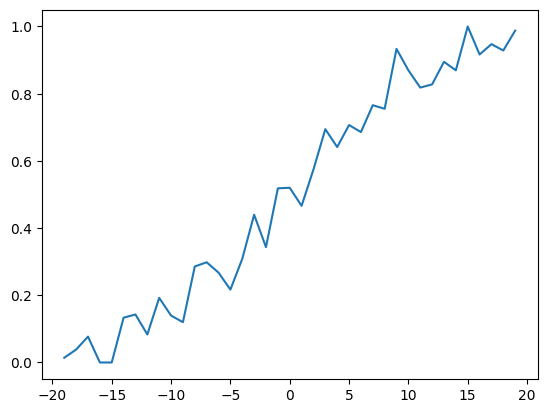

In [169]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [171]:
spline_model = []
for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
#     spline_fit = np.clip(spline_fit,0.02,0.98)
#     spline_fit[(df_train.T1_seed==1) & (df_train.T2_seed==16) & (df_train.T1_Score > df_train.T2_Score)] = 1.0
#     spline_fit[(df_train.T1_seed==16) & (df_train.T2_seed==1) & (df_train.T1_Score < df_train.T2_Score)] = 0.0
#     spline_fit[(df_train.T1_seed==2) & (df_train.T2_seed==15) & (df_train.T1_Score > df_train.T2_Score)] = 1.0
#     spline_fit[(df_train.T1_seed==15) & (df_train.T2_seed==2) & (df_train.T1_Score < df_train.T2_Score)] = 0.0
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.554441127884987
logloss of cvsplit 1: 0.551173600282934
logloss of cvsplit 2: 0.5536143746829623
logloss of cvsplit 3: 0.5509056517344104
logloss of cvsplit 4: 0.5544565203807561
logloss of cvsplit 5: 0.5536508813723601
logloss of cvsplit 6: 0.5536992236383367
logloss of cvsplit 7: 0.553339555799367
logloss of cvsplit 8: 0.5518702730020042
logloss of cvsplit 9: 0.5513524292949332


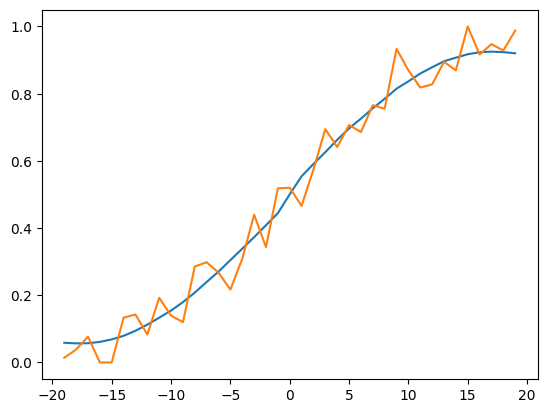

In [172]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [173]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )


Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [174]:
sub["ScoreDiff"] = sub['T1_Scoremean'] - sub['T2_Scoremean']
sub = sub.fillna(0)
if normalize == "MinMaxScaler":
    min_max_scaler = preprocessing.MinMaxScaler()
    sub[features] = min_max_scaler.fit_transform(sub[features])
elif normalize == "StandardScaler":
    min_max_scaler = preprocessing.StandardScaler()
    sub[features] = min_max_scaler.fit_transform(sub[features])
elif normalize == "Normalizer":
    min_max_scaler = preprocessing.Normalizer(norm='max')
    sub[features] = min_max_scaler.fit_transform(sub[features])

X_sub = sub[features].values
index_season = sub.loc[sub.Season == 2023].index
X = X_sub[index_season]
dtest = xgb.DMatrix(X)

sub_preds = []
for i in range(repeat_cv):
    subm = sub_models[i].predict(dtest)
    sub_preds.append(np.clip(spline_model[i](np.clip(subm,-30,30)),0.025,0.975))
    sub.loc[index_season, "Pred"] = pd.DataFrame(sub_preds).mean(axis = 0).values
        

C:\Users\81809\AppData\Local\Temp\ipykernel_5504\3329885018.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub = sub.fillna(0)


In [206]:
sub.describe()

,Pred,women,men,flag
count,130683.000000,130683.000000,130683.000000,130683.000000
mean,0.499986,0.499707,0.500279,0.497234
std,0.047473,0.038281,0.028073,0.499994
min,0.031571,0.031571,0.054815,0.000000
25%,0.500000,0.500000,0.500000,0.000000
50%,0.500000,0.500000,0.500000,0.000000
75%,0.500000,0.500000,0.500000,1.000000
max,0.960520,0.960520,0.937665,1.000000


In [203]:
sub_men = pd.read_csv(os.path.join(INPUT_PATH, 'SampleSubmission2023.csv'))
sub_men.columns = ['ID', 'ignore']
sub_men = pd.merge(sub_men, sub[['ID', 'Pred']], on =  'ID', how = 'left')
sub_men.fillna(0.5, inplace = True)
sub_men.drop(['ignore'], axis = 1, inplace = True)

In [204]:
sub_men.head()

,ID,Pred
0,2023_1101_1102,0.5
1,2023_1101_1103,0.5
2,2023_1101_1104,0.5
3,2023_1101_1105,0.5
4,2023_1101_1106,0.5


# woman

In [176]:
tourney_results = pd.read_csv(os.path.join(INPUT_PATH,'WNCAATourneyDetailedResults.csv'))
seeds = pd.read_csv(os.path.join(INPUT_PATH,'WNCAATourneySeeds.csv'))
regular_results = pd.read_csv(os.path.join(INPUT_PATH, 'WRegularSeasonDetailedResults.csv'))

regular_results['WEFFG'] = regular_results['WFGM'] / regular_results['WFGA']
regular_results['WEFFG3'] = regular_results['WFGM3'] / regular_results['WFGA3']
regular_results['WDARE'] = regular_results['WFGM3'] / regular_results['WFGM']
regular_results['WTOQUETOQUE'] = regular_results['WAst'] / regular_results['WFGM']

regular_results['LEFFG'] = regular_results['LFGM'] / regular_results['LFGA']
regular_results['LEFFG3'] = regular_results['LFGM3'] / regular_results['LFGA3']
regular_results['LDARE'] = regular_results['LFGM3'] / regular_results['LFGM']
regular_results['LTOQUETOQUE'] = regular_results['LAst'] / regular_results['LFGM']
tourney_results.Season.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021,
       2022, 2023, 2024], dtype=int64)

In [177]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

boxscore_cols = ['T1_Score', 'T2_Score',
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff', 'T1_EFFG', 'T1_EFFG3', 'T1_DARE', 'T1_TOQUETOQUE', 'T2_EFFG', 'T2_EFFG3', 'T2_DARE', 'T2_TOQUETOQUE']
# Choose a function to aggregate
funcs = [np.mean]
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2131927037.py:10: FutureWarning: The provided callable <function mean at 0x0000018EA9263880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()


,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,...,T2_Blkmean,PointDiffmean,T1_EFFGmean,T1_EFFG3mean,T1_DAREmean,T1_TOQUETOQUEmean,T2_EFFGmean,T2_EFFG3mean,T2_DAREmean,T2_TOQUETOQUEmean
0,2010,3102,51.821429,71.785714,19.142857,53.142857,4.571429,16.071429,12.464286,10.250000,...,5.035714,-19.964286,0.450980,0.428571,0.260870,0.565217,0.315789,0.370370,0.555556,0.722222
1,2010,3103,62.233333,59.633333,22.233333,55.266667,3.933333,12.466667,14.200000,13.433333,...,3.800000,2.600000,0.431636,0.367010,0.180574,0.597717,0.333201,0.251383,0.214533,0.511845
2,2010,3104,64.137931,67.000000,24.724138,62.103448,4.344828,14.724138,14.482759,13.103448,...,3.586207,-2.862069,0.470421,0.364594,0.176810,0.608955,0.359990,0.264098,0.188905,0.519286
3,2010,3105,60.777778,64.740741,20.370370,50.851852,3.037037,9.888889,13.666667,9.740741,...,4.407407,-3.962963,0.460352,0.380924,0.147840,0.518459,0.357016,0.253358,0.172346,0.615866
4,2010,3106,55.137931,57.413793,18.448276,53.000000,2.689655,9.586207,15.000000,11.482759,...,3.965517,-2.275862,0.397221,0.325099,0.117332,0.613966,0.305125,0.227372,0.165109,0.475473


In [178]:
if PREVIOUS_SEASONS_WOMEN:
    features_for_calc = ["T1_Scoremean", "T1_FGAmean",  "T1_FGA3mean"]
    season_statistics_with_3_seas = write_mean_of_3_seasons(
        season_statistics, features_for_calc, degree_weight=1.0
    )
    season_statistics_T1 = season_statistics_with_3_seas.copy()
    season_statistics_T2 = season_statistics_with_3_seas.copy()
else:
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

season_statistics_T1[1000:1003]

  0%|          | 0/5602 [00:00<?, ?it/s]C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.82142857142857' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.142857142857146' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.071428571428573' has dtype incompatible with int64, please explicitl

,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,...,T1_EFFG3mean,T1_DAREmean,T1_TOQUETOQUEmean,T2_EFFGmean,T2_EFFG3mean,T2_DAREmean,T2_TOQUETOQUEmean,T1_Scoremean_mn3s,T1_FGAmean_mn3s,T1_FGA3mean_mn3s
1000,2012,3434,51.482759,57.034483,18.586207,50.931034,3.965517,15.724138,10.724138,10.482759,...,0.395093,0.257315,0.607398,0.317777,0.234035,0.276770,0.585580,54.711111,53.637931,17.794636
1001,2012,3435,71.903226,60.870968,26.354839,56.612903,5.322581,14.387097,12.935484,15.419355,...,0.411083,0.208247,0.611044,0.349521,0.284342,0.236963,0.488155,71.345830,56.266761,15.043405
1002,2012,3436,58.821429,62.071429,21.035714,61.392857,5.750000,20.107143,15.678571,12.357143,...,0.323219,0.223711,0.573315,0.341323,0.232582,0.127447,0.467037,56.403187,57.575640,18.199091


In [179]:
# "T1_Scoremean",  "T1_Scoremean_mn3s" - values are different
# "T1_FGAmean", "T1_FGAmean_mn3s"      - values are different
# "T1_FGA3mean", "T1_FGA3mean_mn3s"    - values are different
if PREVIOUS_SEASONS_WOMEN:
    season_statistics_T1[["T1_Scoremean", "T1_Scoremean_mn3s", 
                          "T1_FGAmean", "T1_FGAmean_mn3s",
                          "T1_FGA3mean", "T1_FGA3mean_mn3s" ]][1000:1003]

In [180]:
season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

# We don't have the box score statistics in the prediction bank. So drop it.
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2010,138,3124,69,3201,55
1,2010,138,3173,67,3395,66
2,2010,138,3181,72,3214,37
3,2010,138,3199,75,3256,61
4,2010,138,3207,62,3265,42


In [181]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(7968, 5)

In [182]:
# This is metric to measure the team's strength, in this case, this is a logistic regression and we
# the coefficients
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024),
                         #team_quality(2025)
                        ]).reset_index(drop=True)

0.9962327097083752 0.969051093427595
0.8204741108684237 0.3758754360202108


c:\Users\81809\anaconda3\envs\deep_learning_pytorch\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.201287736688012 2.8585730357291506
2.6021148415160766 1.2454952007933164
2.4797938845876244 1.3310153927018002


c:\Users\81809\anaconda3\envs\deep_learning_pytorch\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.5861095049618115 1.1409951823072233
2.699921334430455 0.5907803208574597
2.591674961968806 1.1200684722487155
2.570780758900818 1.0827963308361663
2.656351456294791 0.7684606398280918


c:\Users\81809\anaconda3\envs\deep_learning_pytorch\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


0.8336692886113377 0.29989204594680774
0.7982827280208232 0.3260874944602523
1.0706185340536791 0.940105310305051
1.006869698997249 0.8124799043613619


In [183]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data.head(3)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,...,T2_TOQUETOQUEmean,T2_opponent_EFFGmean,T2_opponent_EFFG3mean,T2_opponent_DAREmean,T2_opponent_TOQUETOQUEmean,T2_Scoremean_mn3s,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality
0,2010,138,3124,69,3201,55,72.093750,56.84375,26.093750,56.343750,...,0.578349,0.397614,0.269271,0.171999,0.499706,73.454545,61.575758,24.848485,1.097234,0.385861
1,2010,138,3173,67,3395,66,70.769231,59.50000,25.884615,61.538462,...,0.605916,0.342404,0.259221,0.254091,0.575936,72.300000,62.266667,19.200000,1.070782,1.038745
2,2010,138,3181,72,3214,37,71.593750,55.06250,26.843750,63.750000,...,0.569006,0.355679,0.270391,0.134569,0.347931,62.833333,60.100000,16.100000,1.158375,0.141439


In [184]:
tourney_data['T1_quality'].fillna(0.2, inplace = True)
tourney_data['T2_quality'].fillna(0.2, inplace = True)
tourney_data.T2_quality.isnull().sum()

seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head(3)

C:\Users\81809\AppData\Local\Temp\ipykernel_5504\3601095142.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tourney_data['T1_quality'].fillna(0.2, inplace = True)
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\3601095142.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

,Season,Seed,TeamID,seed
0,1998,W01,3330,1
1,1998,W02,3163,2
2,1998,W03,3112,3


In [185]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

#Optional but not relevant
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

if PREVIOUS_SEASONS_WOMEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    tourney_data_with_3_seas = write_mean_of_3_seasons(tourney_data, features_for_calc, degree_weight=1.0)
    tourney_data = tourney_data_with_3_seas.copy()

tourney_data[1000:1002]

  0%|          | 0/1788 [00:00<?, ?it/s]C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0972341237081427' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.398896127797391' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.666666666666667' has dtype incompatible with int64, please explicitly

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,...,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
1000,2011,141,3199,59,3208,61,73.900000,64.733333,26.033333,59.333333,...,59.634409,17.032258,1.023350,0.950507,3,6,-3,1.046659,3.090289,3.000000
1001,2011,141,3462,75,3257,85,74.413793,55.103448,28.068966,61.068966,...,57.452586,17.520833,1.039314,0.986014,2,7,-5,1.058183,1.544864,2.333333


In [186]:
if PREVIOUS_SEASONS_WOMEN:
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"] +\
        ["T1_quality_mn3s", "T2_quality_mn3s", "T1_seed_mn3s"]
else:
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"] 

print(len(features))

72


In [187]:
sub = pd.read_csv(os.path.join(INPUT_PATH, 'SampleSubmissionStage1.csv'))
sub["Season"] = sub["ID"].apply(lambda x: x[0:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.shape

(507108, 5)

In [188]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left') 
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
print(sub.shape)
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
print(sub.shape)
sub.head(3)

(251443, 69)
(251443, 71)
(8850, 73)
(8850, 74)


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T2_opponent_DAREmean,T2_opponent_TOQUETOQUEmean,T2_Scoremean_mn3s,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2021_3104_3112,0.5,2021,3104,3112,74.8,70.04,25.92,59.52,8.2,...,0.258843,0.519741,67.791091,59.055300,18.929339,0.911158,1.107017,7,3,4
1,2021_3104_3116,0.5,2021,3104,3116,74.8,70.04,25.92,59.52,8.2,...,0.237055,0.462039,81.436547,64.173815,24.889434,0.911158,0.986292,7,4,3
2,2021_3104_3124,0.5,2021,3104,3124,74.8,70.04,25.92,59.52,8.2,...,0.268165,0.540403,81.496644,65.060069,10.409144,0.911158,0.953870,7,2,5


In [189]:
print(sub.T2_quality.isnull().sum())
sub['T1_quality'].fillna(0.2, inplace = True)
sub['T2_quality'].fillna(0.2, inplace = True)
print(sub.T2_quality.isnull().sum())

if PREVIOUS_SEASONS_WOMEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    sub = write_mean_of_3_seasons(sub, features_for_calc, degree_weight=1.0)
    sub = sub.copy()
sub.head(3)

C:\Users\81809\AppData\Local\Temp\ipykernel_5504\4098840319.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sub['T1_quality'].fillna(0.2, inplace = True)
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\4098840319.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

241
0


  0%|          | 0/8850 [00:00<?, ?it/s]C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9111579111263524' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3294122507372797' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
 74%|███████▍  | 6554/8850 [00:51<00:08, 270.23it/s]C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.6666666666666667

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
0,2021_3104_3112,0.5,2021,3104,3112,74.8,70.04,25.92,59.52,8.2,...,59.055300,18.929339,0.911158,1.107017,7,3,4,0.911158,0.329412,7.0
1,2021_3104_3116,0.5,2021,3104,3116,74.8,70.04,25.92,59.52,8.2,...,64.173815,24.889434,0.911158,0.986292,7,4,3,0.911158,0.329412,7.0
2,2021_3104_3124,0.5,2021,3104,3124,74.8,70.04,25.92,59.52,8.2,...,65.060069,10.409144,0.911158,0.953870,7,2,5,0.911158,0.329412,7.0


In [190]:
teamdata = pd.read_csv(os.path.join(INPUT_PATH, 'WTeams.csv'))
sub = pd.merge(sub, teamdata, left_on = 'T1_TeamID', right_on = 'TeamID', how = 'left')
sub = pd.merge(sub, teamdata, left_on = 'T2_TeamID', right_on = 'TeamID', how = 'left')
sub.head(3)

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s,TeamID_x,TeamName_x,TeamID_y,TeamName_y
0,2021_3104_3112,0.5,2021,3104,3112,74.8,70.04,25.92,59.52,8.2,...,7,3,4,0.911158,0.329412,7.0,3104,Alabama,3112,Arizona
1,2021_3104_3116,0.5,2021,3104,3116,74.8,70.04,25.92,59.52,8.2,...,7,4,3,0.911158,0.329412,7.0,3104,Alabama,3116,Arkansas
2,2021_3104_3124,0.5,2021,3104,3124,74.8,70.04,25.92,59.52,8.2,...,7,2,5,0.911158,0.329412,7.0,3104,Alabama,3124,Baylor


In [191]:
normalize = "Normalizer"

param = {} 
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 #recommend change to ~0.02 for final run. Higher when debugging.
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10. Write 3 for debugging.
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] = 3 
# param['silent'] = 1
if USE_GPU: 
    param['tree_method'] ='gpu_hist'
df = tourney_data.copy()
df.insert(0,"ID","")
df.ID = [str(row.Season)+"_"+str(row.T1_TeamID)+"_"+str(row.T2_TeamID)for _, row in df.iterrows()]
df = df.fillna(0)
df["ScoreDiff"] = df['T1_Score'] - df['T2_Score']

if normalize == "MinMaxScaler":
    min_max_scaler = preprocessing.MinMaxScaler()
    df[features] = min_max_scaler.fit_transform(df[features])
elif normalize == "StandardScaler":
    min_max_scaler = preprocessing.StandardScaler()
    df[features] = min_max_scaler.fit_transform(df[features])
elif normalize == "Normalizer":
    min_max_scaler = preprocessing.Normalizer(norm='max')
    df[features] = min_max_scaler.fit_transform(df[features])
season = 2022
repeat_cv = 10 # 4 recommend 10 for final submission. Smaller for debugging.
seasons = df['Season'].unique().tolist()
pred_tests = []
target = "ScoreDiff" 
print("Seasons:", seasons)
print(f'Validating on season: {season}')

df_train = df[df['Season'] <= season].reset_index(drop=True).copy()
df_val = df[df['Season'] == season].reset_index(drop=True).copy()
y = df_train[target] 
X = df_train[features].values
dtrain = xgb.DMatrix(X, label = y)

Seasons: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]
Validating on season: 2022


In [192]:
xgb_cv = []
for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:16.83401+0.12429	test-mae:16.84002+0.50892
[50]	train-mae:11.65692+0.10172	test-mae:11.98282+0.45095
[100]	train-mae:10.29518+0.09356	test-mae:10.83905+0.42705
[150]	train-mae:9.72658+0.09053	test-mae:10.47706+0.42965
[200]	train-mae:9.38001+0.09174	test-mae:10.34043+0.40701
[250]	train-mae:9.12099+0.09459	test-mae:10.27897+0.39563
[300]	train-mae:8.90506+0.09595	test-mae:10.25992+0.39558
[350]	train-mae:8.71289+0.09823	test-mae:10.25824+0.39748
[355]	train-mae:8.69446+0.09840	test-mae:10.25868+0.39617
Fold repeater 1
[0]	train-mae:16.83468+0.28557	test-mae:16.84207+1.16615
[50]	train-mae:11.65662+0.14539	test-mae:11.99909+0.91592
[100]	train-mae:10.28155+0.12187	test-mae:10.88987+0.73401
[150]	train-mae:9.71088+0.11443	test-mae:10.54818+0.64677
[200]	train-mae:9.36931+0.12073	test-mae:10.40753+0.60681
[250]	train-mae:9.11170+0.11572	test-mae:10.35962+0.59286
[300]	train-mae:8.89578+0.11171	test-mae:10.34242+0.57865
[317]	train-mae:8.82664+0.10866	test-mae

In [193]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([330, 293, 339, 398, 391, 316, 347, 281, 321, 331],
 [10.256409607317886,
  10.341507418688973,
  10.250960150321848,
  10.277068458889662,
  10.282603170173733,
  10.294119646321786,
  10.304241112109862,
  10.26595320285935,
  10.298077151767519,
  10.288204448630935])

In [194]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-19,19))

Fold repeater 0


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -2.088595    28.759195     6.6438246    5.844914     9.153525
  31.375689    16.867306    -0.9647973   22.381523     6.0303626
  24.20889      3.943377     3.1191418   25.777905     6.452341
 -11.252695    -9.607765     4.4123206   42.40624      1.9673797
  11.209657    -1.423251     6.2801976   -8.933669    -8.955927
  15.478342    -5.1109886   12.44541     35.34318     15.944275
  36.97496     -7.6050315   15.763864     2.6120517   13.598272
  21.083927    14.751642    19.602533    -2.734639    -8.3292675
  14.563213    20.792904     1.6695279   28.802101    13.151592
  18.896036     9.946097    -0.4586942   -6.851095    -4.7635593
   7.491159     0.58035785  38.288055    -8.651129    13.16768
  47.486366    12.450319    18.198013    23.877178    12.977678
  13.430579     6.060102    25.08

Fold repeater 1


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 21.510351    -0.75745916  -2.5385695    2.2120657   -7.574934
  15.89441     -1.2754508    5.286736    -4.1668334   22.21673
  10.80492     35.52187     41.159153    22.800161    18.30641
  10.777758    35.66206     26.147552    27.155054    19.988117
  28.848766   -10.775377    -7.543849     2.1334434    9.992692
  -4.525605    13.467663    27.773903     2.8363218   35.726135
  29.512257    -7.7037435    9.90756     -9.456227    12.351961
  22.43088      3.2156022   45.15258     -8.048856     3.35019
  23.61928      0.33856964  29.594238     0.3660086   -4.3660693
   7.500461    19.567684     3.5605643    1.3987502   -0.7031715
  21.719315     1.8235444   30.321518    44.82878      2.8785365
  14.287532    -8.737441    28.656696    29.161604     5.9220276
  37.841167    23.569544    10.1818

Fold repeater 2


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 30.190243    42.449917    18.187227    32.821762    24.786743
   4.237741     3.3362935   -9.585733    18.928854    10.011528
  -2.4839528    4.4008284    9.58422     34.74042     17.675856
  28.738747    20.05792     12.000527    13.088938   -12.02456
  30.180769    32.83056      2.179606    29.775978     2.3920014
  12.3532095    1.5723517   23.49685      5.653536    -1.8566825
   1.3020225    9.279146     1.5393482    9.737539    -7.6704082
  -1.3484071   25.099567   -11.555319    14.260066    16.970772
   2.1601648    6.98732     21.492834     9.659482    45.37974
  22.19321      2.760578    17.235092    -1.4012545   12.338492
 -10.6890545    9.127719     0.6323485    8.540375    21.388075
   6.8466315    9.440163    23.160425    -4.3556056   44.76241
  22.505585    -4.2409744    7.48377

Fold repeater 3


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -0.18376444  21.084276     9.233648    13.531535    -3.5944614
   0.7160847    5.8605733   -2.950049    25.718956    25.9229
  13.775531    16.316526     9.132704     4.5870447    9.765206
  21.667614     4.6657243   13.795698    25.976309    18.217157
  17.265137    22.466423    -5.502887    12.392433    14.135512
  -7.611       27.362255    32.716682     3.096403    26.790907
  18.815687     8.520378     1.9214737   -1.0085753   28.4819
  28.581448     3.6517506    3.1060975   -3.574397    -1.7649488
   4.409345    -6.261834     2.241725     2.548046    12.150835
   1.7907225   31.457476     8.786522    19.851582     4.582829
 -10.825876    29.510977    -1.880881     2.9144957    8.642121
   9.719939     8.456492     2.5430522    2.5134945   47.175766
  -4.2208447   30.97053     13.828365 

Fold repeater 4


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  6.775796     6.6670856   14.78315     34.325687     5.1266217
  27.405073     4.8089604   33.26268      8.6174       3.8714309
  19.574083    25.801146    11.587284    15.536958    -0.77975255
   8.53743     39.78744     16.66197     34.739067     1.385061
  17.949785    12.099796    -3.058704     4.0462513    1.5763015
  19.109854     1.9927927   13.615123     7.290816     0.7338331
  28.310986     5.446831    28.16885     29.190712     3.8400333
   6.139049    29.793442    -3.4752738   19.406643    -9.113259
  16.509016     1.8521384   -0.26147965   2.3814466   -4.0221796
  29.86376     -2.07652     -1.4774913   -1.4509288    3.5254183
  37.93506     -8.727837    -0.9450404   14.154333    28.505146
   2.415375    12.145979    -1.8040069   13.279618   -11.669134
  -1.068381     6.1194515  

Fold repeater 5


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.63068981e+01  2.10182514e+01  1.27736588e+01  5.30677843e+00
  5.90507150e-01  2.52110748e+01  1.59443159e+01  4.56519318e+00
  3.38312817e+00  4.56653214e+00  3.48778992e+01  2.10366559e+00
 -9.50212002e+00  5.20373487e+00  4.55261856e-01  1.25754309e+01
  6.64953995e+00  2.47252693e+01  4.56832838e+00  1.37151659e+00
  3.14746590e+01 -6.21963263e+00  2.84900513e+01  1.42218137e+00
 -9.91318512e+00  7.05448198e+00  2.56742573e+01  2.56241531e+01
  1.80408154e+01 -2.78076887e+00  1.94125462e+01 -7.98438025e+00
  2.93673306e+01 -2.86784196e+00  2.13415489e+01  1.56797409e+01
  1.94357567e+01  1.72732124e+01  2.82100964e+01 -5.80788946e+00
  1.01424265e+01  7.23536539e+00  2.03955803e+01  3.03163319e+01
 -1.39776453e-01  2.37368450e+01  1.99796505e+01  1.70990181e+01
  3.54267159e+01  2.9194

Fold repeater 6


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 13.9122505   27.850895    14.091166     1.2246076   29.88768
  24.417141    23.93414     -3.8620808    3.3190622    1.4791304
  33.12512     22.678814    -7.9973407   -2.3613677   18.899057
   0.16274719  20.735514    36.97887      4.9329066   37.535027
   2.8901815   12.899417     3.1419065   17.145529     2.6692574
  17.409979    -5.5495524   20.854973     1.1932157    1.7611754
   2.4785752    4.7149596   31.6452       1.0081934   16.827597
   7.3115535   35.08451      4.8125253    8.986676     3.3272438
  18.489632     3.9446845    4.9653416   -6.725651    16.726364
  27.31378      9.108798    28.82651      1.3371814   10.070396
  18.152632     7.0832157    1.2710894   -0.37601268   6.4602504
  29.223434    36.633762     8.186525     3.4665637   44.15353
  -9.434978     9.620055    12.93

Fold repeater 7


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  7.9968762    7.7453723   33.12469     25.726221    43.93007
  30.30556     16.816906    -5.341317     2.9607394    4.389828
   4.738596    11.782994    -9.555383    -0.5132227   -6.219951
  20.423042    22.504148    28.12904     36.673374     6.0640025
   4.677725    18.349457    27.932266    -5.757209     1.8718574
   1.0644827   14.328355    27.238392     1.831454    19.167252
  41.721756     0.720713    -0.1170565   13.112536    -5.919545
   5.051322   -16.693085     7.897526     9.555808    24.927462
  10.876615     4.1156096   10.698523     6.054589    21.976698
   3.1937354    1.5894599    0.09979185  10.875921     9.112198
  -1.8893033   14.441659    15.431022     9.762784    -3.6474278
  19.437777    10.171345     5.698854    -0.44525295   9.464143
  18.721067    20.837536    -9.357

Fold repeater 8


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.80527711e-01  2.50155525e+01  3.19329953e+00  3.41847343e+01
  1.38683548e+01  4.71403450e-01  6.46230268e+00  2.00177155e+01
  2.06618786e+01  1.72952099e+01  2.16463985e+01 -3.03549194e+00
  3.40461121e+01  2.16059799e+01  4.05113335e+01  2.10144463e+01
  1.44236736e+01  2.44080710e+00  1.65499363e+01  2.85336075e+01
  1.97714119e+01  2.08095455e+01 -6.55236101e+00  2.11189442e+01
 -4.24009189e-02  7.94200480e-01 -5.81965685e+00  6.49106169e+00
 -2.13001156e+00  2.57777271e+01  1.36551666e+01  1.41816635e+01
  2.86960793e+01  5.00728369e+00 -1.60329189e+01  5.10353994e+00
  3.78281140e+00 -8.62372780e+00 -1.08968773e+01  1.23661337e+01
  1.89808006e+01  2.23495331e+01  3.39809442e+00  1.40082808e+01
 -8.53936100e+00 -1.41825342e+00  1.87003193e+01  1.66949615e+01
  2.88124905e+01  2.9282

Fold repeater 9


C:\Users\81809\AppData\Local\Temp\ipykernel_5504\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.91640549e+01  7.61494970e+00  1.18919258e+01  7.45983791e+00
  2.48238239e+01  2.58222771e+01  9.82966709e+00  7.33520079e+00
 -6.97924948e+00  1.33680525e+01  4.14035857e-01  2.27154026e+01
 -2.42812967e+00  1.68576527e+01  3.49525185e+01  4.10152130e+01
  1.12203732e+01 -7.54550934e+00 -7.59407234e+00  2.09980717e+01
  1.11550112e+01 -4.74163628e+00  2.69514523e+01  1.49643350e+00
  2.95866241e+01  1.41760426e+01  3.00420589e+01  1.75603237e+01
  9.58517075e+00  4.22030300e-01  3.02477818e+01  2.83312607e+01
  6.60370493e+00  1.23973799e+01  5.73411894e+00  3.03961315e+01
  3.36880493e+01  6.32802391e+00  1.14099407e+01  3.09215698e+01
  7.39701223e+00 -7.16236413e-01  1.99091187e+01  2.34995174e+00
 -4.73511124e+00  1.76637635e-01  2.90809956e+01 -6.86764896e-01
  2.09398365e+01  2.8371

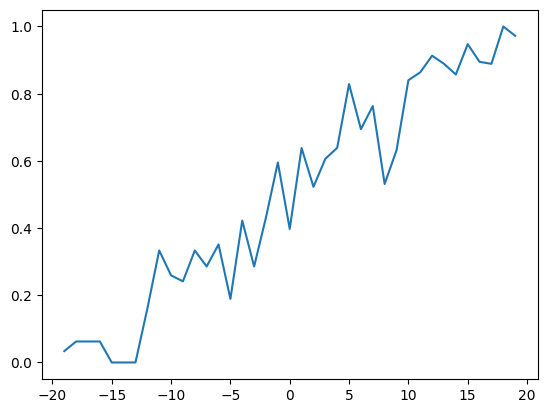

In [195]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [196]:
spline_model = []
for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
#     spline_fit = np.clip(spline_fit,0.02,0.98)
#     spline_fit[(df_train.T1_seed==1) & (df_train.T2_seed==16) & (df_train.T1_Score > df_train.T2_Score)] = 1.0
#     spline_fit[(df_train.T1_seed==16) & (df_train.T2_seed==1) & (df_train.T1_Score < df_train.T2_Score)] = 0.0
#     spline_fit[(df_train.T1_seed==2) & (df_train.T2_seed==15) & (df_train.T1_Score > df_train.T2_Score)] = 1.0
#     spline_fit[(df_train.T1_seed==15) & (df_train.T2_seed==2) & (df_train.T1_Score < df_train.T2_Score)] = 0.0
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.44332391088299283
logloss of cvsplit 1: 0.44542678662812946
logloss of cvsplit 2: 0.44183002528252174
logloss of cvsplit 3: 0.6158288058169034
logloss of cvsplit 4: 0.44687892435823545
logloss of cvsplit 5: 0.4476991479894776
logloss of cvsplit 6: 0.4438646988032614
logloss of cvsplit 7: 0.4430638565166568
logloss of cvsplit 8: 0.443158732130684
logloss of cvsplit 9: 0.45067146446035605


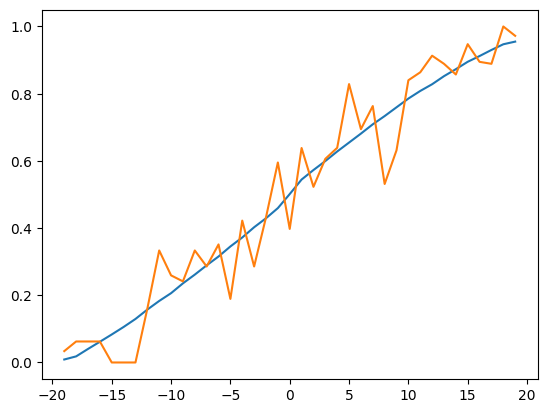

In [197]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [198]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [199]:
sub["ScoreDiff"] = sub['T1_Scoremean'] - sub['T2_Scoremean']
sub = sub.fillna(0)
if normalize == "MinMaxScaler":
    min_max_scaler = preprocessing.MinMaxScaler()
    sub[features] = min_max_scaler.fit_transform(sub[features])
elif normalize == "StandardScaler":
    min_max_scaler = preprocessing.StandardScaler()
    sub[features] = min_max_scaler.fit_transform(sub[features])
elif normalize == "Normalizer":
    min_max_scaler = preprocessing.Normalizer(norm='max')
    sub[features] = min_max_scaler.fit_transform(sub[features])

X_sub = sub[features].values
index_season = sub.loc[sub.Season == 2023].index
X = X_sub[index_season]
dtest = xgb.DMatrix(X)

sub_preds = []
for i in range(repeat_cv):
    subm = sub_models[i].predict(dtest)
    sub_preds.append(np.clip(spline_model[i](np.clip(subm,-30,30)),0.025,0.975))
    sub.loc[index_season, "Pred"] = pd.DataFrame(sub_preds).mean(axis = 0).values
        
sub_women = pd.read_csv(os.path.join(INPUT_PATH, 'SampleSubmission2023.csv'))
sub_women.columns = ['ID', 'ignore']
sub_women = pd.merge(sub_women, sub[['ID', 'Pred']], on =  'ID', how = 'left')
sub_women.fillna(0.5, inplace = True)
sub_women.drop(['ignore'], axis = 1, inplace = True)
sub_men.columns = ['ID', 'men']
sub_women.columns = ['ID', 'women']
sub = pd.read_csv(os.path.join(INPUT_PATH, 'SampleSubmission2023.csv'))

sub = sub.merge(sub_women, on = 'ID', how = 'left').merge(sub_men, on = 'ID', how = 'left')
sub.loc[sub.ID.str[-4:].astype('int') >= 3000, 'flag'] = 1
sub.fillna(0, inplace = True)
sub['Pred'] = sub['men']
sub.loc[sub.flag == 1, 'Pred'] = sub.loc[sub.flag == 1, 'women']
sub[['ID', 'Pred']].to_csv("submission.csv", index = None)
sub.shape

(130683, 5)

In [200]:
"""scoring_2023 = "scoring-2023/scoring_126_games_2023_total.csv"
scoring = pd.read_csv(scoring_2023)
scoring["Pred_prob"] = sub[['ID', 'Pred']].Pred
scoring = scoring.loc[scoring.Usage == 'Public']
y_true = scoring.Pred.tolist()
y_prob = scoring.Pred_prob.tolist()
brier_score_loss(y_true, y_prob)"""

'scoring_2023 = "scoring-2023/scoring_126_games_2023_total.csv"\nscoring = pd.read_csv(scoring_2023)\nscoring["Pred_prob"] = sub[[\'ID\', \'Pred\']].Pred\nscoring = scoring.loc[scoring.Usage == \'Public\']\ny_true = scoring.Pred.tolist()\ny_prob = scoring.Pred_prob.tolist()\nbrier_score_loss(y_true, y_prob)'

In [201]:
"""scoring[["ID","Pred_prob", "Pred"]]"""

'scoring[["ID","Pred_prob", "Pred"]]'